In [1]:
import torch

In [2]:
words = open('names.txt' , 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1,ch2 in zip(chs , chs[1:]):
        bigram = (ch1 , ch2)
        b[bigram] = b.get(bigram , 0) + 1

In [5]:
# sorted(b.items(), key=lambda kv : -kv[1])

In [6]:
N = torch.zeros((27,27) , dtype=torch.int32)

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['<.>'] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
for w in words:
    chs = ['<.>'] + list(w) + ['<.>']
    for ch1,ch2 in zip(chs , chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1 , ix2] +=1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

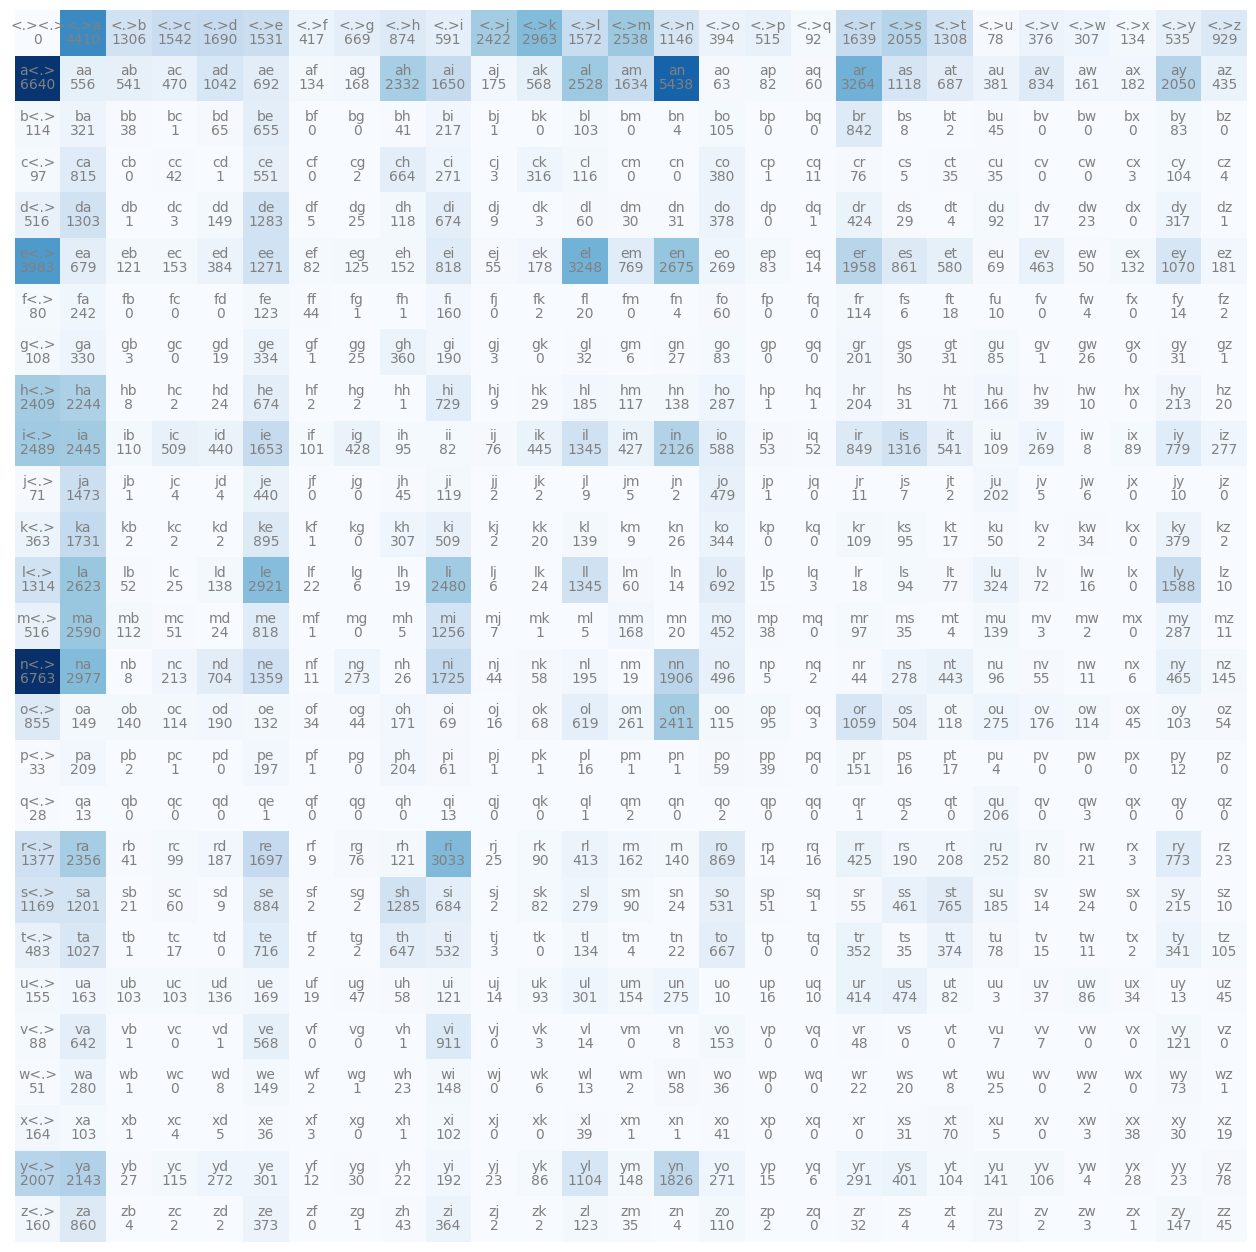

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [10]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [11]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p , num_samples=1 , replacement=True , generator=g).item()
itos[ix]

'c'

In [12]:
P=(N+1).float()
P /=P.sum(1 , keepdim=True)

In [13]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    outlist = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p , num_samples=1 , replacement=True , generator=g).item()
        outlist.append(itos[ix])
        if ix ==0:
            break

    print(''.join(outlist))

cexze<.>
momasurailezitynn<.>
konimittain<.>
llayn<.>
ka<.>
da<.>
staiyaubrtthrigotai<.>
moliellavo<.>
ke<.>
teda<.>
ka<.>
emimmsade<.>
enkaviyny<.>
ftlspihinivenvorhlasu<.>
dsor<.>
br<.>
jol<.>
pen<.>
aisan<.>
ja<.>


In [14]:
for w in words[:3]:
    chs = ['<.>'] + list(w) + ['<.>']
    for ch1,ch2 in zip(chs , chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1 , ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')

<.>e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a<.>: 0.1958
<.>o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a<.>: 0.1958
<.>a: 0.1376
av: 0.0246
va: 0.2473
a<.>: 0.1958


In [15]:
logprob = 0
n=0
for w in words:
    chs = ['<.>'] + list(w) + ['<.>']
    for ch1,ch2 in zip(chs , chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1 , ix2]
        n+=1
        logprob += torch.log(prob)
        
print(f'{logprob:.4f}')
neg_log = -logprob
print(f'{neg_log/n :.4f}')

-559951.5625
2.4544


**Neural Network Approach**

In [16]:
#creating a dataset
xs , ys = [] , []
for w in words:
    chs = ['<.>'] + list(w) + ['<.>']
    for ch1,ch2 in zip(chs , chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("no of examples: " , num)

no of examples:  228146


In [17]:
#1 Hot Encoding 
import torch.nn.functional as F
xenc = F.one_hot(xs , num_classes=27).float()

In [18]:
W = torch.randn((27,27))
xenc @ W

tensor([[ 1.0643, -0.6782, -1.1734,  ..., -1.1515,  0.3700, -0.9585],
        [ 1.1593, -0.6326, -0.5778,  ..., -1.6660, -1.2687, -0.9176],
        [-1.1152, -1.5821, -0.6122,  ...,  0.4408,  1.1804,  1.9646],
        ...,
        [ 1.1733,  1.7734,  0.6588,  ..., -0.0608, -0.6134, -0.4672],
        [-0.8186, -0.3530, -2.3697,  ...,  0.1130,  0.7880, -0.9775],
        [ 1.3267, -0.4738,  0.2862,  ...,  0.3492,  0.7432, -0.6202]])

In [19]:
logits = xenc @ W
counts = logits.exp()
prob = counts / counts.sum(1 , keepdim=True)

In [20]:
prob.shape

torch.Size([228146, 27])

In [21]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', prob[i])
  print('label (actual next character):', y)
  p = prob[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: <.>e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0569, 0.0100, 0.0061, 0.0017, 0.0136, 0.0147, 0.0523, 0.0295, 0.0072,
        0.0022, 0.0052, 0.0556, 0.0617, 0.1224, 0.0080, 0.0103, 0.0050, 0.3432,
        0.0156, 0.0103, 0.0436, 0.0462, 0.0229, 0.0137, 0.0062, 0.0284, 0.0075])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.014675299637019634
log likelihood: -4.2215895652771
negative log likelihood: 4.2215895652771
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.1335, 0.0223, 0.0235, 0.0221, 0.0029, 0.1515, 0.0191, 0.0184, 0.0427,
        0.0180, 0.0735, 0.0132, 0.0469, 0.0223, 0.0823, 0.0221, 0.0191, 0.0373,
        0.0579, 0.0770, 0.0154, 0.0077, 0.0326, 0.0024, 0.0079, 0.0118, 0.0167])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.0

In [22]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27) , generator=g , requires_grad=True)

In [24]:
xenc = F.one_hot(xs , num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
prob = counts / counts.sum(1 , keepdim=True)
loss = -prob[torch.arange(n) , ys].log().mean()
print(loss.item())

3.758953332901001


In [25]:
#backward pass

W.grad = None
loss.backward()

In [26]:
W.data += -0.1*W.grad

In [27]:
(W**2).mean()

tensor(0.9663, grad_fn=<MeanBackward0>)

In [28]:
for k in range(100):
    xenc = F.one_hot(xs , num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    prob = counts / counts.sum(1 , keepdim=True)
    loss = -prob[torch.arange(num) , ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    W.grad = None
    loss.backward()
    W.data += -10.0*W.grad


3.76770281791687
3.6786270141601562
3.5992040634155273
3.527806520462036
3.4633686542510986
3.4051167964935303
3.3524224758148193
3.3047358989715576
3.26153826713562
3.2223329544067383
3.1866509914398193
3.154057741165161
3.1241681575775146
3.0966482162475586
3.0712156295776367
3.047632932662964
3.0257012844085693
3.0052542686462402
2.986149549484253
2.968264579772949
2.951493263244629
2.9357409477233887
2.920923948287964
2.906966209411621
2.8937997817993164
2.8813626766204834
2.869598627090454
2.858455181121826
2.8478870391845703
2.8378493785858154
2.8283042907714844
2.8192155361175537
2.8105509281158447
2.8022797107696533
2.79437518119812
2.7868123054504395
2.7795684337615967
2.7726223468780518
2.7659549713134766
2.759549140930176
2.7533888816833496
2.7474591732025146
2.741746664047241
2.736238479614258
2.730924129486084
2.725792169570923
2.7208328247070312
2.716038465499878
2.7113993167877197
2.706908702850342
2.702558755874634
2.6983439922332764
2.6942572593688965
2.690293073654175

In [29]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]) , num_classes=27).float()
        logits = xenc@W
        counts = logits.exp()
        p = counts / counts.sum(1 , keepdim=True)
        ix = torch.multinomial(p , num_samples=1 , replacement=True , generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break

    print(''.join(out))

cexza<.>
mogllurailezityha<.>
konimittain<.>
llayn<.>
ka<.>
